In [1]:
%matplotlib notebook
import numpy as np
import pickle, gzip
import matplotlib.pyplot as plt
import time

In [5]:
pwd

'C:\\Notebooks'

In [2]:
def initalize_weights_relu(size_layer, size_next_layer):
    np.random.seed(5)
    # Method presented in "Delving Deep into Rectifiers: Surpassing Human-Level Performance on ImageNet Classfication"
    # He et Al. 2015
    epsilon = np.sqrt(2.0 / (size_layer * size_next_layer) )
    # Weigts from Normal distribution mean = 0, std = epsion
    w = epsilon * (np.random.randn(size_next_layer, size_layer))
    return w.transpose()
def load_mnist():
    # Import MNIST data
    with gzip.open('mnist.pkl.gz', 'rb') as f:
        train_set, valid_set, test_set = pickle.load(f, encoding='latin1')
    # Training data, only
    X = valid_set[0]
    y = valid_set[1]

    # change y [1D] to Y [2D] sparse array coding class
    n_examples = len(y)
    labels = np.unique(y)
    Y = np.zeros((n_examples, len(labels)))
    for ix_label in range(len(labels)):
        # Find examples with with a Label = lables(ix_label)
        ix_tmp = np.where(y == labels[ix_label])[0]
        Y[ix_tmp, ix_label] = 1

    return X, Y, labels, y

In [3]:
# -*- coding: utf-8 -*-
"""
Parameters of MLP
Number of layers : 3 (input, hidden1, output)
Elements in layers : [784, 100, 10] // 784 pixels softmax = 10
Activation function : Rectified Linear function //RELU
Regularization parameter : 0
Bias element added in input layers : False

This file contains the Multi-Layer Perceptron (MLP) class which creates a
fully-connected-feedforward-artifitial-neural-network object with methods
for its usage
Methods:
    __init__()
    train(X, y, iterations, reset)
    predict(X)
    initialize_theta_weights()
    backpropagation(X, Y)
    feedforward(X)
    unroll_weights(rolled_data)
    roll_weights(unrolled_data)
    sigmoid(z)
    relu(z)
    sigmoid_derivative(z)
    relu_derivative(z)
"""
import numpy as np

class Mlp():
    '''
    fully-connected Multi-Layer Perceptron (MLP)
    '''

    def __init__(self, size_layers, act_f='sigmoid', reg_lambda=0, bias_flag=True):
        '''
        Constructor method. Defines the characteristics of the MLP
        Arguments:
            size_layers : List with the number of Units for:
                [Input, Hidden1, Hidden2, ... HiddenN, Output] Layers.
            act_f   : Activation function for all the Units in the MLP
                default = 'sigmoid'
            reg_lambda: Value of the regularization parameter Lambda
                default = 0, i.e. no regularization
            bias: Indicates is the bias element is added for each layer, but the output
        '''
        """Missing code
        Fill in the init function.
        """
        self.n_layers = len(size_layers)
        self.size_layers = size_layers
        self.act_f = act_f
        self.lambda_r = reg_lambda
        self.bias_flag = bias_flag
        
        # Ramdomly initialize theta (MLP weights)
        self.initialize_theta_weights()

    def train(self, X, Y, iterations=400, reset=False):
        '''
        Given X (feature matrix) and y (class vector)
        Updates the Theta Weights by running Backpropagation N tines
        Arguments:
            X          : Feature matrix [n_examples, n_features]
            Y          : Sparse class matrix [n_examples, classes]
            iterations : Number of times Backpropagation is performed
                default = 400
            reset      : If set, initialize Theta Weights before training
                default = False
        '''
        n_examples = Y.shape[0]
#        self.labels = np.unique(y)
#        Y = np.zeros((n_examples, len(self.labels)))
#        for ix_label in range(len(self.labels)):
#            # Find examples with with a Label = lables(ix_label)
#           ix_tmp = np.where(y == self.labels[ix_label])[0]
#            Y[ix_tmp, ix_label] = 1

        if reset:
            self.initialize_theta_weights()
        for iteration in range(iterations):
            self.gradients = self.backpropagation(X, Y)
            self.gradients_vector = self.unroll_weights(self.gradients)
            self.theta_vector = self.unroll_weights(self.theta_weights)
            self.theta_vector = self.theta_vector - self.gradients_vector
            self.theta_weights = self.roll_weights(self.theta_vector)

    def predict(self, X):
        '''
        Given X (feature matrix), y_hay is computed
        Arguments:
            X      : Feature matrix [n_examples, n_features]
        Output:
            y_hat  : Computed Vector Class for X
        '''
        A , Z = self.feedforward(X)
        Y_hat = A[-1]
        return Y_hat

    def initialize_theta_weights(self):
        '''
        Initialize theta_weights, initialization method depends
        on the Activation Function and the Number of Units in the current layer
        and the next layer.
        The weights for each layer as of the size [next_layer, current_layer + 1]
        '''
        self.theta_weights = []
        size_next_layers = self.size_layers.copy()
        size_next_layers.pop(0)
        for size_layer, size_next_layer in zip(self.size_layers, size_next_layers):
            if self.act_f == 'sigmoid':
                # Method presented "Understanding the difficulty of training deep feedforward neurla networks"
                # Xavier Glorot and Youshua Bengio, 2010
                epsilon = 4.0 * np.sqrt(6) / np.sqrt(size_layer + size_next_layer)
                # Weigts from a uniform distribution [-epsilon, epsion]
                if self.bias_flag:  
                    theta_tmp = epsilon * ( (np.random.rand(size_next_layer, size_layer + 1) * 2.0 ) - 1)
                else:
                    theta_tmp = epsilon * ( (np.random.rand(size_next_layer, size_layer) * 2.0 ) - 1)            
            elif self.act_f == 'relu':
                # Method presented in "Delving Deep into Rectifiers: Surpassing Human-Level Performance on ImageNet Classfication"
                # He et Al. 2015
                epsilon = np.sqrt(2.0 / (size_layer * size_next_layer) )
                # Weigts from Normal distribution mean = 0, std = epsion
                if self.bias_flag:
                    theta_tmp = epsilon * (np.random.randn(size_next_layer, size_layer + 1 ))
                else:
                    theta_tmp = epsilon * (np.random.randn(size_next_layer, size_layer))                    
            self.theta_weights.append(theta_tmp)
        return self.theta_weights

    def backpropagation(self, X, Y):
        '''
        Implementation of the Backpropagation algorithm with regularization
        '''
        if self.act_f == 'sigmoid':
            g_dz = lambda x: self.sigmoid_derivative(x)
        elif self.act_f == 'relu':
            g_dz = lambda x: self.relu_derivative(x)

        n_examples = X.shape[0]
        # Feedforward
        A, Z = self.feedforward(X)

        # Backpropagation
        deltas = [None] * self.n_layers
        deltas[-1] = A[-1] - Y
        # For the second last layer to the second one
        for ix_layer in np.arange(self.n_layers - 1 - 1 , 0 , -1):
            theta_tmp = self.theta_weights[ix_layer]
            if self.bias_flag:
                # Removing weights for bias
                theta_tmp = np.delete(theta_tmp, np.s_[0], 1)
            deltas[ix_layer] = (np.matmul(theta_tmp.transpose(), deltas[ix_layer + 1].transpose() ) ).transpose() * g_dz(Z[ix_layer])

        # Compute gradients
        gradients = [None] * (self.n_layers - 1)
        for ix_layer in range(self.n_layers - 1):
            grads_tmp = np.matmul(deltas[ix_layer + 1].transpose() , A[ix_layer])
            grads_tmp = grads_tmp / n_examples
            if self.bias_flag:
                # Regularize weights, except for bias weigths
                grads_tmp[:, 1:] = grads_tmp[:, 1:] + (self.lambda_r / n_examples) * self.theta_weights[ix_layer][:,1:]
            else:
                # Regularize ALL weights
                grads_tmp = grads_tmp + (self.lambda_r / n_examples) * self.theta_weights[ix_layer]       
            gradients[ix_layer] = grads_tmp;
        return gradients

    def feedforward(self, X):
        '''
        Implementation of the Feedforward
        '''
        if self.act_f == 'sigmoid':
            g = lambda x: self.sigmoid(x)
        elif self.act_f == 'relu':
            g = lambda x: self.relu(x)

        A = [None] * self.n_layers
        Z = [None] * self.n_layers
        input_layer = X

        for ix_layer in range(self.n_layers - 1):
            n_examples = input_layer.shape[0]
            if self.bias_flag:
                # Add bias element to every example in input_layer
                input_layer = np.concatenate((np.ones([n_examples ,1]) ,input_layer), axis=1)
            A[ix_layer] = input_layer
            # Multiplying input_layer by theta_weights for this layer
            Z[ix_layer + 1] = np.matmul(input_layer,  self.theta_weights[ix_layer].transpose() )
            # Activation Function
            output_layer = g(Z[ix_layer + 1])
            # Current output_layer will be next input_layer
            input_layer = output_layer

        A[self.n_layers - 1] = output_layer
        return A, Z


    def unroll_weights(self, rolled_data):
        '''
        Unroll a list of matrices to a single vector
        Each matrix represents the Weights (or Gradients) from one layer to the next
        '''
        unrolled_array = np.array([])
        for one_layer in rolled_data:
            unrolled_array = np.concatenate((unrolled_array, one_layer.flatten(1)) )
        return unrolled_array

    def roll_weights(self, unrolled_data):
        '''
        Unrolls a single vector to a list of matrices
        Each matrix represents the Weights (or Gradients) from one layer to the next
        '''
        size_next_layers = self.size_layers.copy()
        size_next_layers.pop(0)
        rolled_list = []
        if self.bias_flag:
            extra_item = 1
        else:
            extra_item = 0
        for size_layer, size_next_layer in zip(self.size_layers, size_next_layers):
            n_weights = (size_next_layer * (size_layer + extra_item))
            data_tmp = unrolled_data[0 : n_weights]
            data_tmp = data_tmp.reshape(size_next_layer, (size_layer + extra_item), order = 'F')
            rolled_list.append(data_tmp)
            unrolled_data = np.delete(unrolled_data, np.s_[0:n_weights])
        return rolled_list

    def sigmoid(self, z):
        #Sigmoid function
        #z can be an numpy array or scalar
    
        result =  1.0 / (1.0 + np.exp(-z))
        #Fill in the Sigmoid function. The input for the Sigmoid can be a scalar or a numpy array
    
        return result

    def relu(self, z):
        
        #Rectified Linear function
        #z can be an numpy array or scalar
        
        if np.isscalar(z):
            result = np.max((z, 0))
        #Fill in the Relu function for a scalar input
        else:
            zero_aux = np.zeros(z.shape)
            meta_z = np.stack((z , zero_aux), axis = -1)
            result = np.max(meta_z, axis = -1)
        return result

    def sigmoid_derivative(self, z):
        '''
        Derivative for Sigmoid function
        z can be an numpy array or scalar
        '''
        result = self.sigmoid(z) * (1-self.sigmoid(z))
        """
        Fill in the Sigmoid derivative function. The input for the Sigmoid derivative function can be a scalar or a numpy array
        """
        return result

    def relu_derivative(self, z):
        '''
        Derivative for Rectified Linear function
        z can be an numpy array or scalar
        '''
        result = 1 * (z > 0)
        return result

In [4]:
def plot_digits(X, y, num_digits_to_plot=3):
    for i in range(num_digits_to_plot):
        _image = X[i,:]
        _label = y[i]

        # 784 columns correspond to 28x28 image
        plottable_image = np.reshape(_image, (28, 28))

        # Plot the image
        plt.figure()
        plt.imshow(plottable_image, cmap='gray_r')
        plt.title('Digit Label: {}'.format(_label))
        plt.show()

<IPython.core.display.Javascript object>


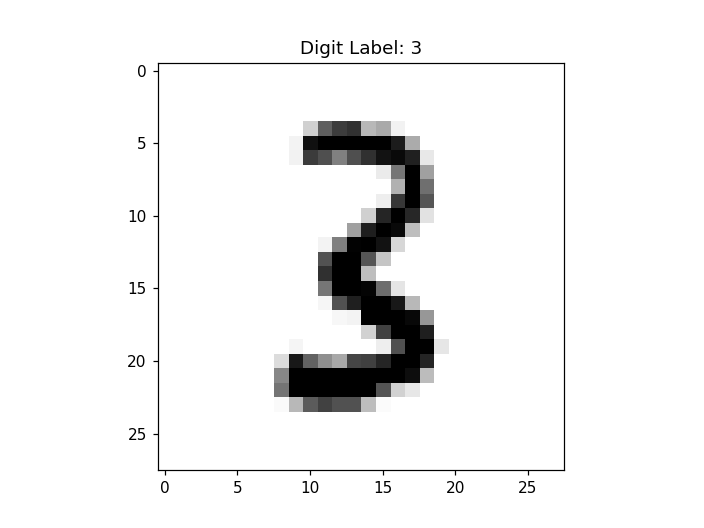

<IPython.core.display.Javascript object>


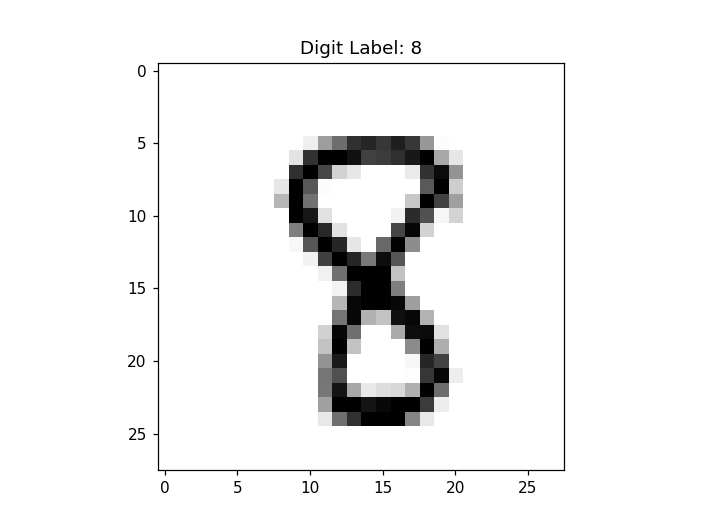

<IPython.core.display.Javascript object>


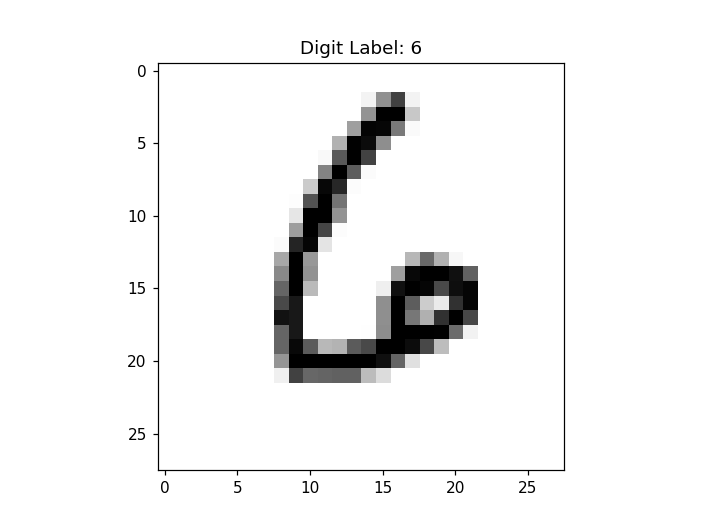

<IPython.core.display.Javascript object>


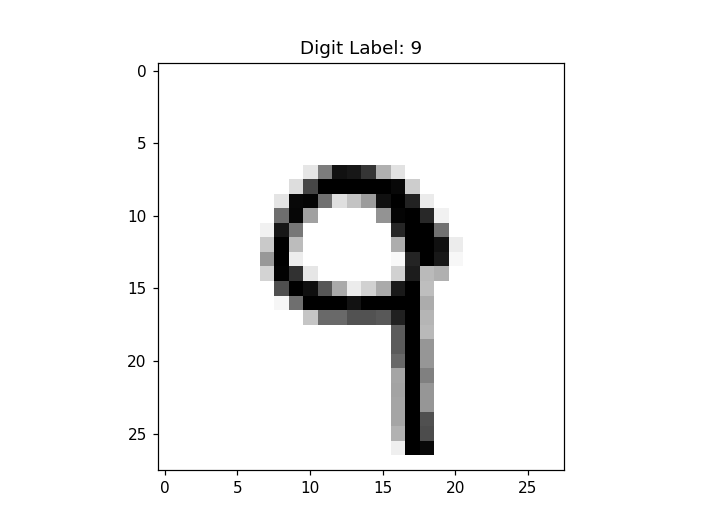

<IPython.core.display.Javascript object>


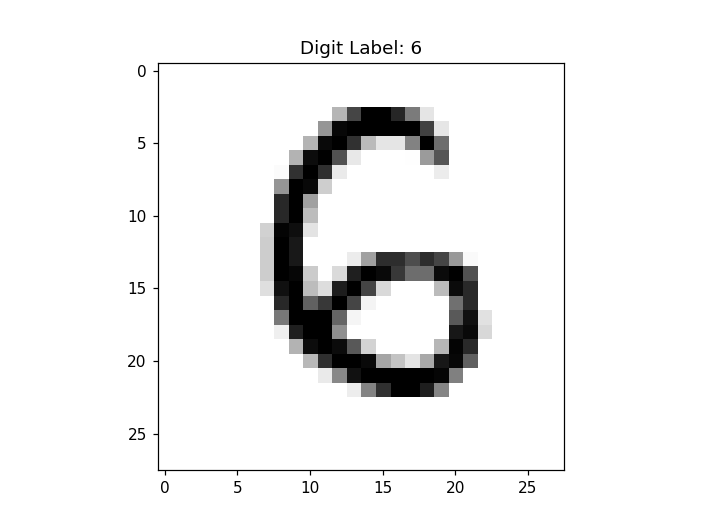

<IPython.core.display.Javascript object>


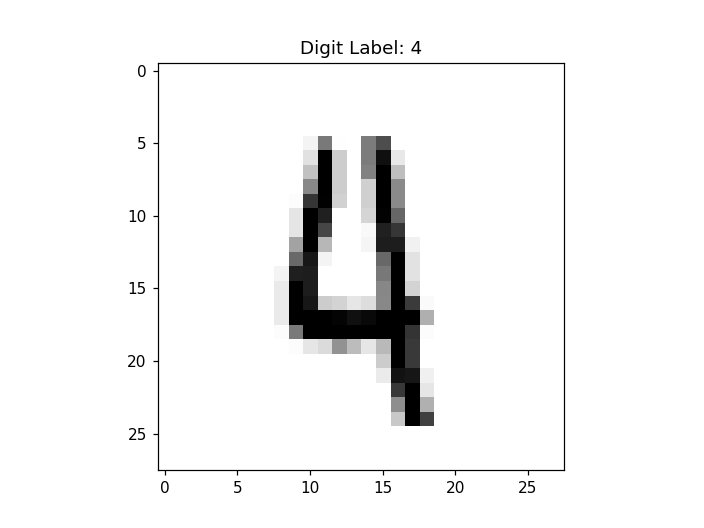

<IPython.core.display.Javascript object>


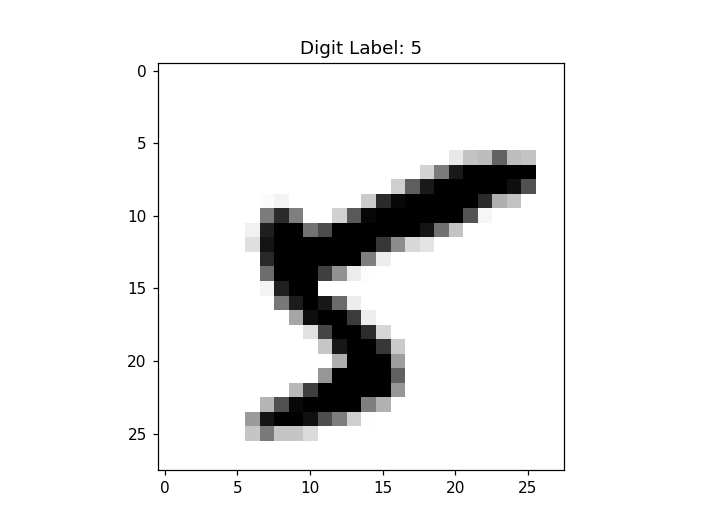

<IPython.core.display.Javascript object>


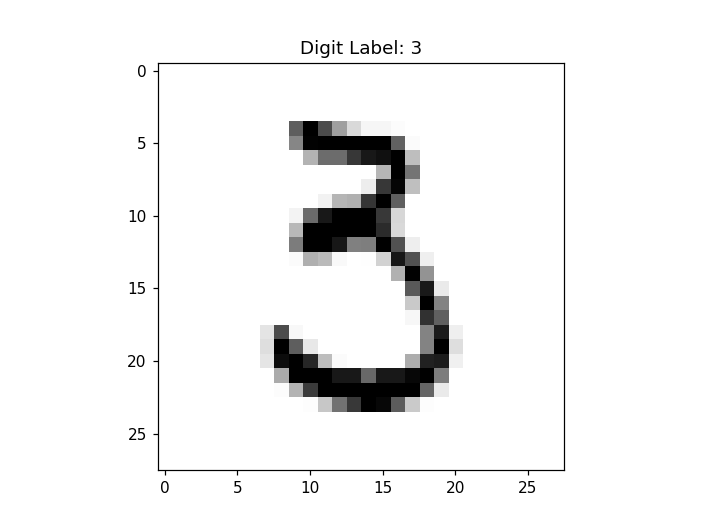

<IPython.core.display.Javascript object>


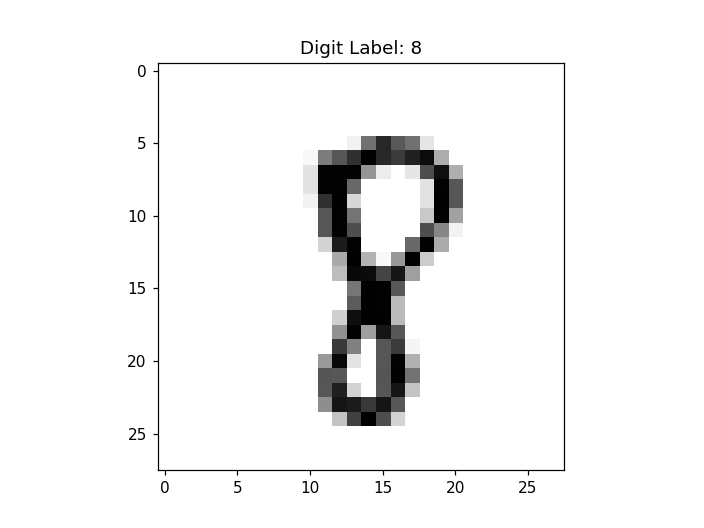

<IPython.core.display.Javascript object>


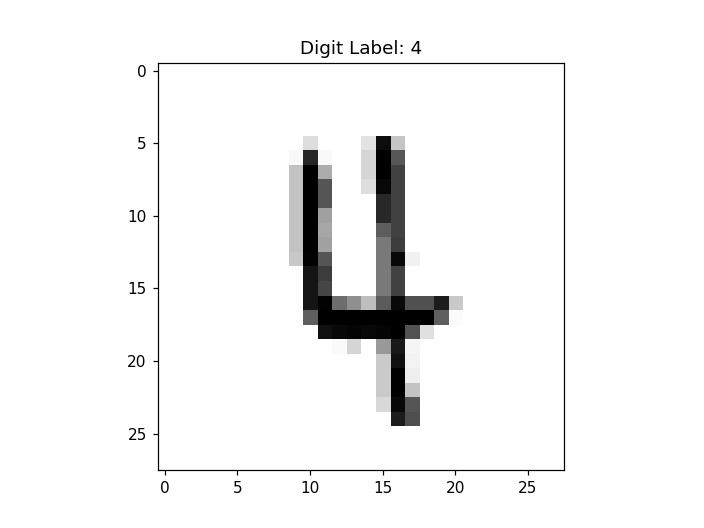

num examples by num of features (10000, 784)


In [5]:
# Load data
X, Y, labels, y = load_mnist()
plot_digits(X, y, num_digits_to_plot=10)
print('num examples by num of features', X.shape)

In [ ]:
tic = time.time()
epochs = 110 
loss = np.zeros([epochs,1])
# Creating the MLP object initialize the weights
mlp_classifier = Mlp(size_layers = [784, 110 , 10], 
                         act_f   = 'sigmoid',
                         reg_lambda  = 0,
                         bias_flag   = False)

for ix in range(epochs):
    mlp_classifier.train(X, Y,12 )
    Y_hat = mlp_classifier.predict(X)
    # loss
    loss[ix] = (0.5)*np.square(Y_hat - Y).mean()

print(str(time.time() - tic) + ' s')
        
# Ploting loss vs epochs
plt.figure()
ix = np.arange(epochs)
plt.plot(ix, loss)

# Training Accuracy
Y_hat = mlp_classifier.predict(X)
y_tmp = np.argmax(Y_hat, axis=1)
y_hat = labels[y_tmp]

acc = np.mean(1 * (y_hat == y))
print('Training Accuracy: ' + str(acc*100) + '%')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:206: DeprecationWarning: Non-string object detected for the array ordering. Please pass in 'C', 'F', 'A', or 'K' instead
